In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from stochastic_simulation import StochasticSimulation
from sir_stochastic_sim import SIRStochasticSimulation

In [17]:
def sim_many_test_days(base_params, test_days, use_SIR_dynamics=False, time_horizon=250, only_bucket_test=True):
    dfs_cts = {}
    dfs_bucket = {}
    base_params_cts = base_params.copy()
    base_params_cts['days_between_tests'] = 1
    
    base_params_bucket = base_params.copy()
    base_params_bucket['test_population_fraction'] = 1
    
    for T in test_days:
        if not only_bucket_test:
            base_params_cts['test_population_fraction'] = 1/T
            if use_SIR_dynamics:
                sim_cts = SIRStochasticSimulation(base_params_cts)
            else:
                sim_cts = StochasticSimulation(base_params_cts)
            dfs_cts[T] = []
            for _ in range(100):
                dfs_cts[T].append(sim_cts.run_new_trajectory(time_horizon))
        
        base_params_bucket['days_between_tests'] = T
        if use_SIR_dynamics:
            sim_bucket = SIRStochasticSimulation(base_params_bucket)
        else:
            sim_bucket = StochasticSimulation(base_params_bucket)
        dfs_bucket[T] = []
        for _ in range(100):
            dfs_bucket[T].append(sim_bucket.run_new_trajectory(time_horizon))
        
        print("Done test frequency {}".format(T))
    
    return dfs_cts, dfs_bucket

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 12

def add_plot(df, params, color='blue', ID_only=False):
    if ID_only:
        cols = ['ID_{}'.format(x) for x in range(params['max_time_ID'])]
    else:
        cols = ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])]
    plt.plot(df[cols].sum(axis=1), linewidth=10.0, alpha=0.1, color=color)    


# just need params to get the proper column names
def plot_sims(dfs1, dfs2, title1, title2, params, ID_only=False):
    plt.figure(figsize=(20,12))

    plt.subplot(2,1,1)
    
    plt.xlabel("Day")
    plt.ylabel("Number of Active Infections")
    plt.title(title1)

    for df in dfs1:
        add_plot(df, params, ID_only=ID_only)

    plt.subplot(2,1,2)
    plt.xlabel("Day")
    plt.ylabel("Number of Active Infections")
    plt.title(title2)
    for df in dfs2:
        add_plot(df, params, color='green', ID_only=ID_only)

    plt.show()

def plot_many_sims(dfs_cts, dfs_bucket, params, ID_only):
    for test_frequency in dfs_cts.keys():
        df_cts = dfs_cts[test_frequency]
        df_bucket = dfs_bucket[test_frequency]
        title_cts = "Trajectory Under Continuous Testing: Test 1/{} Population Every Day".format(test_frequency)
        title_bucket = "Trajectory Under Bucket Testing: Test Everyone Every {} Days".format(test_frequency)
        plot_sims(df_cts, df_bucket, title_cts, title_bucket, params, ID_only)

In [4]:
import numpy as np
from scipy.stats import geom, poisson

import functools

@functools.lru_cache(maxsize=128)
def poisson_pmf(max_time, mean_time):
    pmf = list()
    for i in range(1, max_time):
        pmf.append(poisson.pmf(i, mean_time))
    pmf.append(1-np.sum(pmf))
    return np.array(pmf)



# Cornell May 15 Simulation Parameters

In [13]:
base_params = {
    'max_time_exposed': 4,
    'exposed_time_function': (lambda n: np.random.multinomial(n, poisson_pmf(max_time=4+1, mean_time=1))),
    
    'max_time_pre_ID': 4,
    'pre_ID_time_function': (lambda n: np.random.multinomial(n, poisson_pmf(max_time=4+1, mean_time=1))),
    
    'max_time_ID': 8,
    'ID_time_function': (lambda n: np.random.multinomial(n, poisson_pmf(max_time=8+1, mean_time=4))),
    
    'max_time_SyID_mild': 14,
    'SyID_mild_time_function': (lambda n: np.random.multinomial(n, poisson_pmf(max_time=14+1, mean_time=10))),
    
    'max_time_SyID_severe': 14,
    'SyID_severe_time_function': (lambda n: np.random.multinomial(n, poisson_pmf(max_time=14+1, mean_time=10))),
    
    'sample_QI_exit_function': (lambda n: np.random.binomial(n, 0.05)),
    'sample_QS_exit_function': (lambda n: np.random.binomial(n, 0.3)),
    
    'exposed_infection_p': 0.026,
    'expected_contacts_per_day': 10,
    
    'mild_symptoms_p': 0.4,
    'mild_symptoms_daily_self_report_p': 0.10,
    'severe_symptoms_daily_self_report_p': 0.85,
    
    'days_between_tests': 10,
    'test_population_fraction': 1/10,
    
    'test_protocol_QFNR': 0.1,
    'test_protocol_QFPR': 0.005,
    
    'perform_contact_tracing': False,
    'contact_tracing_constant': 0.7,
    'contact_tracing_delay': 1,
    
    'pre_ID_state': 'detectable',
    
    'population_size': 2000,
    'initial_E_count': 0,
    'initial_pre_ID_count': 2,
    'initial_ID_count': 0,
    'initial_SyID_mild_count': 0,
    'initial_SyID_severe_count': 0
}


In [14]:
sim = StochasticSimulation(base_params)

In [15]:
dfs_cts_seir_8_trace, dfs_bucket_seir_8_trace = sim_many_test_days(base_params=base_params, 
                                                       test_days=[300], 
                                                       use_SIR_dynamics=False, time_horizon=150)

Done test frequency 300


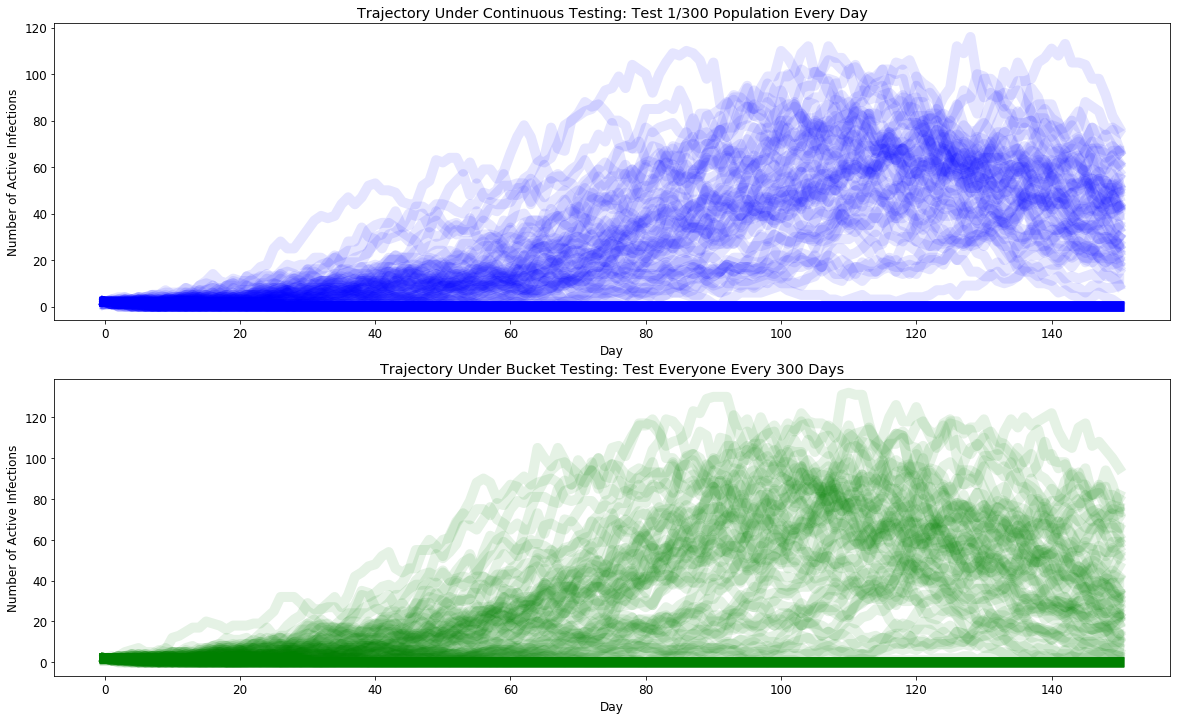

In [16]:
plot_many_sims(dfs_cts_seir_8_trace, dfs_bucket_seir_8_trace, base_params, ID_only=False)

In [18]:
params2 = base_params.copy()
params2['perform_contact_tracing'] = True
params2['contact_tracing_constant'] = 0.3
params2['contact_tracing_delay'] = 5

dfs_cts, dfs_bucket = sim_many_test_days(base_params=params2, 
                                                       test_days=[300], 
                                                       use_SIR_dynamics=False, 
                                         time_horizon=150, 
                                         only_bucket_test=True)

Done test frequency 300


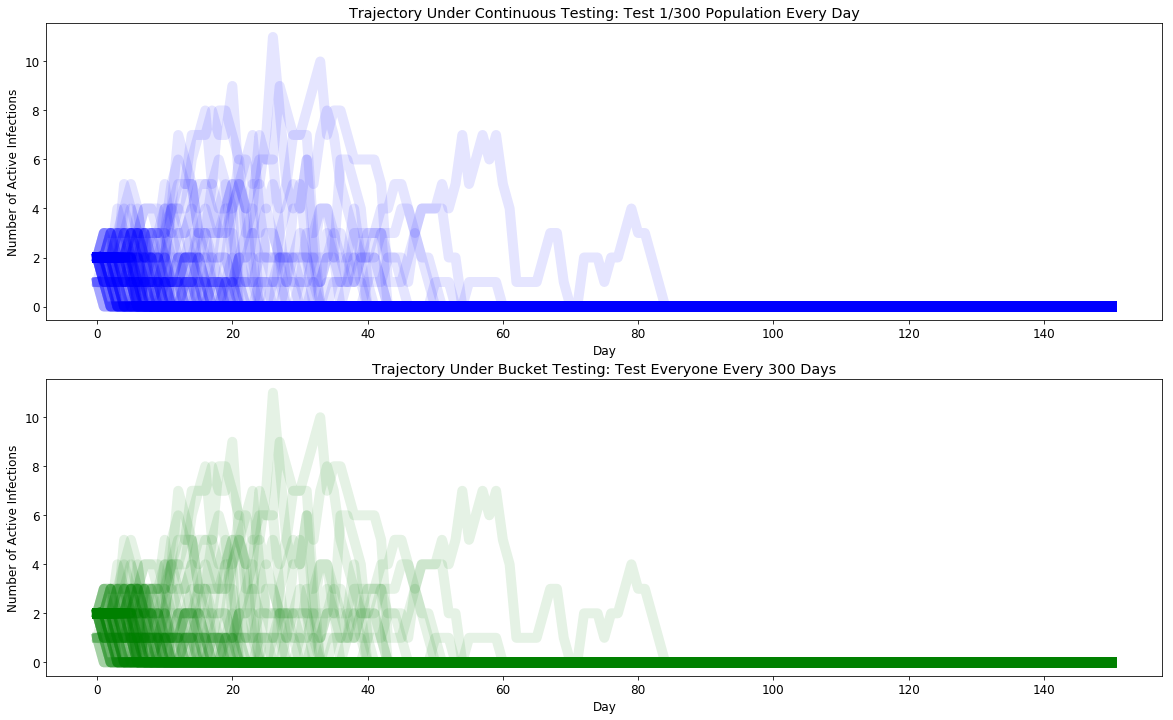

In [19]:
plot_many_sims(dfs_bucket, dfs_bucket, base_params, ID_only=False)